In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import math
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm_notebook
import matplotlib
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 30)

from datetime import datetime
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
path='../input/ashrae-energy-prediction/'

from sklearn.metrics import roc_auc_score,mean_squared_error
from sklearn.model_selection import StratifiedKFold,TimeSeriesSplit, train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import sin,log,pow
import lightgbm as lgb
import datetime
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import multiprocessing as mp
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial
pd.options.mode.chained_assignment = None
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../input/ashrae-energy-prediction/test.csv
../input/ashrae-energy-prediction/weather_train.csv
../input/ashrae-energy-prediction/train.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/building_metadata.csv


In [2]:
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col


def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in tqdm_notebook(df.columns):
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

def chunk_predictor(X,model):
    predict_fold = KFold(50)
    result = np.zeros(X.shape[0])
    for trn_idx, val_idx in tqdm_notebook(predict_fold.split(X)):
           result[val_idx] = model.predict(X.iloc[val_idx,:])
    return(result)

def truncate(number, digits):
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper
def clean_timestamps(df):
    """
    :param df: Dataframe containing a "timestamp" field which will be broken down in hour, year, day,...
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y-%m-%d %H:%M:%S')
    df["month"] = df["timestamp"].dt.month.astype(np.uint8)
    df["day"] = df["timestamp"].dt.day.astype(np.uint8)
    df["hour"] = df["timestamp"].dt.hour.astype(np.uint8)
    df["weekend"] = df["timestamp"].dt.weekday.astype(np.uint8)
def free_space(del_list):
    for name in del_list:
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()
def vector_apply(vec,fun):
    result = vec.copy()
    for i in tqdm_notebook(range(len(vec))):
        result[i] = fun(vec[i])
    return(result)

def res_fun(x):
    return(truncate(math.exp(x)-1,4))

In [3]:
%%time
train = pd.read_csv(f'{path}train.csv')
test = pd.read_csv(f'{path}test.csv')
row_index = test.pop('row_id').copy()
weather_train = pd.read_csv(f'{path}weather_train.csv')
weather_test = pd.read_csv(f'{path}weather_test.csv')

building_metadata = pd.read_csv(f'{path}building_metadata.csv')

weather_all = weather_train.append(weather_test,ignore_index=True)
weather_all['timestamp'] = pd.to_datetime(weather_all['timestamp'],format='%Y-%m-%d %H:%M:%S')


CPU times: user 27.7 s, sys: 6.61 s, total: 34.3 s
Wall time: 33.2 s


In [4]:
%%time

target = np.log1p(train.pop('meter_reading'))
train_row = train.shape[0]

train = train.sample(frac=0.3, random_state=3)
train['target'] = 0

test = test.sample(frac=0.15, random_state=3)
test['target'] = 1

train_all =train.append(test,ignore_index=True)
free_space(['train','test'])
           
#clean_timestamps(train_all)
train_all['timestamp'] = pd.to_datetime(train_all['timestamp'],format='%Y-%m-%d %H:%M:%S')

train_all = train_all.merge(building_metadata, left_on = "building_id", right_on = "building_id", how = "left")
free_space(['building_metadata'])

train_all = train_all.merge(weather_all, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")
free_space(['weather_all'])


CPU times: user 21 s, sys: 6.15 s, total: 27.2 s
Wall time: 26.1 s


In [5]:
%%time
reduce_mem_usage_sd(train_all, obj_to_cat=False)
gc.collect()

train_all.drop(['timestamp','building_id','site_id','primary_use'],axis=1,inplace=True)



Mem. usage decreased from 2318.55 Mb to 1413.90 Mb (39.0% reduction)
CPU times: user 55 s, sys: 9.92 s, total: 1min 4s
Wall time: 1min 1s


In [6]:
target = train_all.pop('target')

In [7]:
# for cat in ['primary_use']:
#     train_all[cat] = LabelEncoder().fit_transform(train_all[cat])

In [8]:
seed = 1
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric': 'auc',
                    'learning_rate':0.3,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'max_bin':255,
                    'seed': seed,
                    'importance_type':'gain',
#                     'early_stopping_rounds':50, 
                    'n_jobs':-1,
                }
feature_importances = pd.DataFrame()
feature_importances['feature'] = train_all.columns


In [9]:
n_fold = 3

folds = StratifiedKFold(n_splits=n_fold, shuffle=True,random_state=0)
score = 0
for fold, (trn_idx, val_idx) in enumerate(folds.split(train_all, target)):
        train_x, train_y = train_all.iloc[trn_idx,:], target.iloc[trn_idx]
        valid_x, valid_y = train_all.iloc[val_idx,:], target.iloc[val_idx]
        model = lgb.train(params,lgb.Dataset(train_x, label=train_y),
                  500)#, valid_sets = lgb.Dataset(valid_x, label=valid_y),verbose_eval=100)
        pred = model.predict(valid_x)
        print('Fold: {} ; AUC Score {}\n'.format(fold,roc_auc_score(valid_y,pred)))
        score += roc_auc_score(valid_y,pred)/n_fold
        feature_importances['fold_{}'.format(fold + 1)] = model.feature_importance()
        del model
        gc.collect()

print('Final AUC Score {}'.format(score))

Fold: 0 ; AUC Score 0.9783603221373637

Fold: 1 ; AUC Score 0.9773453735613737

Fold: 2 ; AUC Score 0.9771470434896155

Final AUC Score 0.977617579729451


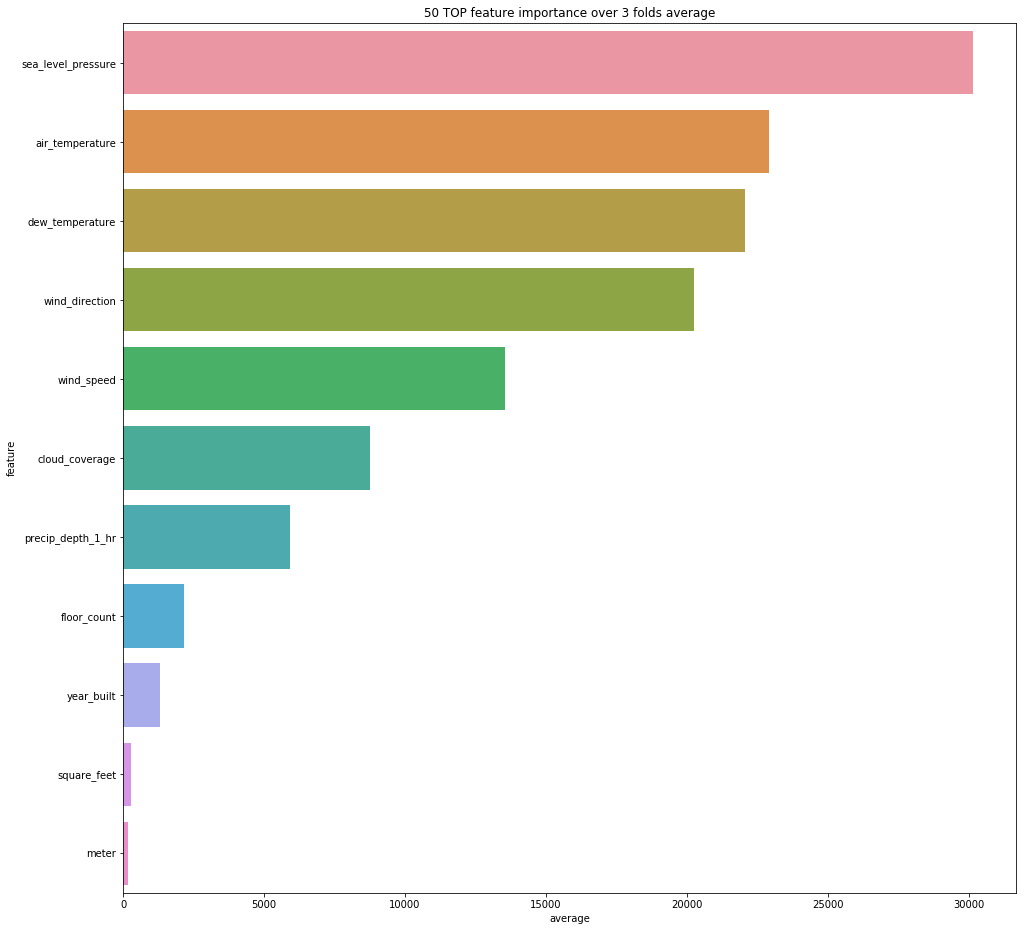

In [10]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
